In [3]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
# Seed control for reproducibility
def set_seed(seed=None):
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

In [ ]:
def dataloader(
    train_size, test_size, data_dir, batch_size, num_workers, total_num=50000
):
    # Setup the transformation
    train_transforms = transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ]
    )

    test_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ]
    )

    train_dataset = torchvision.datasets.CIFAR10(
        root="./data", train=True, transform=train_transforms, download=True
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root="./data", train=False, transform=test_transforms, download=True
    )

    train_indices = np.arange(len(train_dataset))
    np.random.shuffle(train_indices)
    train_indices = train_indices[:train_size]

    test_indices = np.arange(len(test_dataset))
    np.random.shuffle(test_indices)
    test_indices = test_indices[:test_size]

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=SubsetRandomSampler(train_indices),
        num_workers=num_workers,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        sampler=SubsetRandomSampler(test_indices),
        num_workers=num_workers,
    )

    return train_loader, test_loader

In [ ]:
def test(model, dataloader, device):
    model.eval()
    correct, total, loss = 0, 0, 0
    with torch.no_grad():
        for image, label in dataloader:
            image = image.to(device)
            label = label.to(device)
            outputs = model(image)
            _, predicted = torch.max(outputs.data, 1)
            total += label.shape[0]
            correct += (predicted == label).sum().item()
    return correct / total


# Load the log and generate the training line
def log_generation(log_dir):
    # Load the statistics in the log
    epochs, train_rate, test_rate = [], [], []
    with open(log_dir, "r") as f:
        reader = csv.reader(f)
        flag = 0
        for i in reader:
            if flag == 0:
                flag += 1
                continue
            else:
                epochs.append(int(i[0]))
                train_rate.append(float(i[1]))
                test_rate.append(float(i[2]))

    # Generate the success line
    plt.figure(num=0)
    plt.plot(epochs, test_rate, label="test_success_rate", linewidth=2, color="r")
    plt.plot(epochs, train_rate, label="train_success_rate", linewidth=2, color="b")
    plt.xlabel("epoch")
    plt.ylabel("success rate")
    plt.xlim(-1, max(epochs) + 1)
    plt.ylim(0, 1.0)
    plt.title("patch attack success rate")
    plt.legend()
    plt.savefig("training_pictures/patch_attack_success_rate.png")
    plt.close(0)

### Patch generation test

In [5]:
def visualize_patch(patch):
    # Transpose the patch to (height, width, channels) for visualization
    patch_transposed = patch.transpose(1, 2, 0)
    plt.imshow(patch_transposed)
    plt.title("Adversarial Patch")
    plt.axis("off")  # Turn off axis labels
    plt.show()

In [6]:
def patch_initialization(
    patch_type="rectangle", image_size=(3, 32, 32), patch_size=5, seed=None
):
    if seed is not None:
        set_seed(seed)
    if patch_type == "rectangle":
        # Ensure patch size is within the bounds of the image
        patch_height = patch_width = patch_size
        patch = np.random.rand(image_size[0], patch_height, patch_width)
        return patch
    else:
        raise ValueError("Unsupported patch type. Only 'rectangle' is supported.")

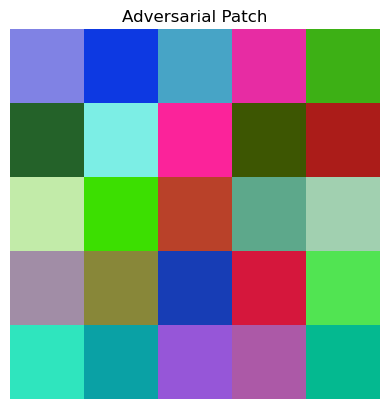

In [9]:
patch = patch_initialization(patch_type="rectangle", patch_size=5)
visualize_patch(patch)

In [ ]:
def mask_generation(mask_type="rectangle", patch=None, image_size=(3, 32, 32)):
    applied_patch = np.zeros(image_size)

    if mask_type == "rectangle":
        # Rotation restricted to 4 directions (0, 90, 180, 270 degrees)
        rotation_angle = np.random.choice(4)
        for i in range(patch.shape[0]):
            patch[i] = np.rot90(patch[i], rotation_angle)

        # Determine a random location within the CIFAR-10 image boundaries
        x_location = np.random.randint(0, image_size[1] - patch.shape[1])
        y_location = np.random.randint(0, image_size[2] - patch.shape[2])

        # Apply the rotated patch at the chosen location
        applied_patch[
            :,
            x_location : x_location + patch.shape[1],
            y_location : y_location + patch.shape[2],
        ] = patch

    # Create a mask to identify where the patch was applied
    mask = applied_patch.copy()
    mask[mask != 0] = 1.0

    return applied_patch, mask, x_location, y_location